**Zusammenfassung Klassifikation im Rahmen CRISP-DM**

- **Business Understanding**
    - Ziel: Churner (`Exited`) erkennen & Kundenerhalt verbessern.
    - Geschäftsparameter (z.B. Kosten für Kundenakquise & -bindung) werden als Variablen (`CAC`, `RC`) gesetzt und sind Grundlage für spätere Kostenoptimierung.

- **Data Understanding & Preparation**
    - (!) Die folgenden Schritte sind Resultat des seperaten EDA Notebooks.
    - Daten werden eingelesen, unnötige Spalten entfernt.
    - Features und Zielvariable getrennt.
    - Aufteilung in Trainings-, Validierungs- und Testdaten (stratifiziert, reproduzierbar via `random_state`).
    - Feature Engineering als Funktion: Neue Merkmale, Transformationen.
    - Preprocessing-Pipeline: Skalierung numerischer und One-Hot-Encoding kategorialer Merkmale für Modellbedingung.
    - Zentrale Pipeline-Bau-Funktion zur flexiblen Integration von Sampler/Modell/Preprocessing.

- **Modeling**
    - Definition und Parametrisierung der Basis-Modelle (LogReg, RF, XGB) inkl. Hyperparameter-Räume für Tuning. #Parametrisierung Orientation an: https://scikit-learn.org/stable/modules/grid_search.html
    - Sampling-Methoden (Over/Under/SMOTE) vorbereitet für spätere Imbalance-Analysen.
    - Pipeline-Architektur unterstützt schnellen Wechsel zwischen Modellen/Sampling.

- **Evaluation**
    - Zentrale Bewertungsmetriken (avg precision, Recall, Precision, Confusion Matrix) für robustere Imbalance Evaluation.
    - Kostenfunktion für Threshold-Optimierung direkt integriert, basiert auf Business-Parametern (`CAC`, `RC`).
    - Kalibrierung und Generalisierungschecks (Learning Curve) für robuste Evaluation.

- **Reproduzierbarkeit & Übersicht**
    - Konsistenter Umgang mit Zufallszahlen (`random.seed`).
    - Strukturierte Ablage von Pfaden und Modellparametern über zentrale Config-Klasse.
    - Klare Trennung von Config, Daten, Modellen und Ergebnissen.

**Fazit:**  
Das Setup bildet die strukturierte Grundlage für einen nach CRISP DM geführten, reproduzierbaren End-to-End-Data-Science-Prozess von Business-Fragestellung bis robuste Modellierung.

*add: Die Projekt-Entscheidungen wie z.B. zur Modellierung, Evaluation oder Wirtschaftlichkeitsanpassungen sind umfassender in der seperaten Hausarbeit literaturbasiert erklärt und hergeleitet.*


# Library

In [1]:
# Generell
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
import seaborn as sns
import pandas as pd
import numpy as np
import random

# Preprocessing & Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import FunctionTransformer

# Hyperparameter Tuning
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score, learning_curve
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

# Modell
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Eval
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    recall_score,
    average_precision_score, 
    precision_recall_curve,
    precision_score, 
    confusion_matrix,
    brier_score_loss
)

# Explainability
import shap

# Config

In [2]:
class Config:
    # Paths
    BASE_DIR    = Path.cwd()
    PATH_DATA   = BASE_DIR / "input" / "data_churn_bank.csv"
    PATH_OUTPUT = BASE_DIR / "output"

    # Business
    CAC = 150    # Customer Acquisition Cost
    RC  = 50     # Retention Cost
                 # Basierend auf der Datensatzbeschreibung wurde CAC als ein unbestimmtes Vielfaches von RC frei gewählt 

    # Modeling 
    RANDOM_STATE    = 42
    TRAIN_RATIO     = 0.7
    VAL_RATIO       = 0.15
    TEST_RATIO      = 0.15
    CV_SPLITS       = 3
    ITER_RANDOM     = 150
    ITER_OPTUNA     = 150
    REFIT_SCORE     = "average_precision" #threshhold unabhängig + imbalance robust -> Solides Fundament für späteres threshhold Anpassung

    COLS_DROP       = ["CustomerId", "Surname", "NumOfProducts"]
    COLS_OHE        = ["Geography", "Gender"]
    COLS_SCALE      = ["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary", "saving_rate"]
    COLS_FE         = ["Balance", "NumOfProducts", "EstimatedSalary"]  # für Feature Engineering transformer
    TARGET_COL      = "Exited"

    # Parameterräume für Hyperparameteroptimierung nach https://scikit-learn.org/stable/modules/grid_search.html
    def __init__(self):
        self.baseline_models = [
            {
                "name": "LogReg", "model": LogisticRegression, 
                "params": {"random_state": self.RANDOM_STATE, "max_iter": 500},
                "class_weight_arg": "class_weight"
            },
            {
                "name": "RF",
                "model": RandomForestClassifier,
                "params": { "random_state": self.RANDOM_STATE},
                "class_weight_arg": "class_weight"
            },
            {
                "name": "XGB",
                "model": XGBClassifier,
                "params": {"eval_metric": "logloss","random_state": self.RANDOM_STATE},
                "class_weight_arg": "scale_pos_weight"
            }
        ]
        self.models = {
            "logreg": LogisticRegression(class_weight="balanced", random_state=self.RANDOM_STATE, max_iter=500),
            "rf": RandomForestClassifier(class_weight="balanced", random_state=self.RANDOM_STATE),
            "xgb": XGBClassifier(eval_metric="logloss", random_state=self.RANDOM_STATE),
        }
        self.param_grids = {
            "logreg": {
                "clf__C": np.logspace(-2, 0, 5),
                "clf__solver": ["liblinear", "saga"],
                "clf__penalty": ["l1", "l2"],
                "clf__class_weight": ["balanced"],
            },
            "rf": {
                "clf__n_estimators": [200, 500],
                "clf__max_depth": [3, 5, 10],
                "clf__min_samples_split": [5, 10],
                "clf__min_samples_leaf": [2, 5, 10],
                "clf__max_features": ["sqrt", "log2"],
                "clf__class_weight": ["balanced"],
            },
            "xgb": {
                "clf__n_estimators": [300, 500],
                "clf__max_depth": [3, 5],
                "clf__learning_rate": [0.01, 0.05],
                "clf__subsample": [0.6, 0.8],
                "clf__colsample_bytree": [0.6, 0.8],
                "clf__gamma": [1, 5],
                "clf__reg_alpha": [0.1, 1, 10],
                "clf__reg_lambda": [2, 5, 10],
                "clf__scale_pos_weight": [4]
            }
        }



cfg = Config()

# Reproduzierbarkeit
random.seed(cfg.RANDOM_STATE)
np.random.seed(cfg.RANDOM_STATE)


# Data collection

In [3]:
df_data = pd.read_csv(cfg.PATH_DATA, index_col=0)
df_data.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited', 'Complain', 'Satisfaction Score',
       'Card Type', 'Point Earned'],
      dtype='object')

In [4]:
# Daten laden
df_data = pd.read_csv(cfg.PATH_DATA, index_col=0)

# UV und Zielvariable trennen
X_full = df_data.drop(columns=[cfg.TARGET_COL])
y_full = df_data[cfg.TARGET_COL]

# Train, Val, Test

In [5]:
# Aufteilung in Trainings-, Validierungs- und Testdatensatz
X_temp, X_test, y_temp, y_test = train_test_split(
    X_full, y_full,
    test_size=cfg.TEST_RATIO,
    random_state=cfg.RANDOM_STATE,
    stratify=y_full
)
val_relative = cfg.VAL_RATIO / (1 - cfg.TEST_RATIO)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_relative,
    random_state=cfg.RANDOM_STATE,
    stratify=y_temp
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (7000, 16), Val: (1500, 16), Test: (1500, 16)


# Pipeline
(!) Die Vorbereitungsschritte in der Pipeline resultieren aus den Erkenntnissen des EDA-Notebooks

## Feature Engineering Transformer

In [6]:
# Erstellung des Feature Engineering Transformers
def add_features(X):
    X = X.copy()
    for col in ["Balance", "NumOfProducts", "EstimatedSalary"]:
        if col not in X.columns:
            X[col] = 0
    X["no_balance"]             = (X["Balance"] == 0).astype(int)
    X["multiproduct"]           = (X["NumOfProducts"] > 1).astype(int)
    X["multiproduct_redflag"]   = (X["NumOfProducts"] > 2).astype(int)
    X["saving_rate"]            = (np.log1p(X["Balance"]) / np.log1p(X["EstimatedSalary"]).replace(0, 1)).clip(lower=0, upper=2) # Winsoring der Sparquote wegen EDA
    X                           = X.drop(columns= ["CustomerId", "Surname"] + ["Complain", "Satisfaction Score"] + ["NumOfProducts"])
    return X

feature_engineering = FunctionTransformer(add_features)

## Preprocessing Pipeline inkl. Imputation

In [7]:
# Erstellung der Preprocessing-Pipeline
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(drop="first")

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, selector(dtype_include=np.number)),
    ("cat", categorical_transformer, selector(dtype_include="object"))
], remainder="passthrough")

## Zentrale Pipeline-Bau-Funktion

In [8]:
# Zusammenfassung der Pipeline
def build_pipeline(model, sampler=None):
    steps = [
        ("feature_eng", feature_engineering),
        ("preprocessing", preprocessor)
    ]
    if sampler is not None:
        steps.append(("sampling", sampler))
    steps.append(("clf", model))
    return ImbPipeline(steps)

# Classification 
## Baseline

In [9]:
results = []
class_weights = ["balanced", None]

for class_weight in class_weights:
    pipe = build_pipeline(
        LogisticRegression(class_weight=class_weight, random_state=cfg.RANDOM_STATE)
    )
    pipe.fit(X_train, y_train)

    y_val_pred  = pipe.predict(X_val)
    y_val_proba = pipe.predict_proba(X_val)[:, 1]

    avg_prec = average_precision_score(y_val, y_val_proba)
    rec  = recall_score(y_val, y_val_pred, zero_division=0)
    prec = precision_score(y_val, y_val_pred, zero_division=0)
    cm   = confusion_matrix(y_val, y_val_pred).tolist()

    results.append({
        "Model": "Logistic Regression",
        "class_weight": class_weight,
        "PR_AUC": avg_prec,
        "Recall": rec,
        "Precision": prec,
        "Confusion_Matrix": cm
    })

round(pd.DataFrame(results),2)

,Model,class_weight,PR_AUC,Recall,Precision,Confusion_Matrix
0,Logistic Regression,balanced,0.58,0.72,0.44,"[[909, 285], [85, 221]]"
1,Logistic Regression,None,0.59,0.37,0.68,"[[1141, 53], [193, 113]]"


**Schlussfolgerungen**
- Gewichtung erhöht Recall, senkt aber Präzision; ohne Gewichtung umgekehrt. 
- Baseline Ergebnisse sind OK für churn -> Es kann weitergemacht werden.


## Hyperprameter Suche

In [10]:
# Erstellung des Stratified K-Fold Cross-Validation Objekts
cv = StratifiedKFold(
    n_splits=cfg.CV_SPLITS,
    shuffle=True,
    random_state=cfg.RANDOM_STATE
)


### Random Search

In [11]:
# Hyperparameteroptimierung mit RandomizedSearchCV
search_results = []
for model_key, model in cfg.models.items():
    param_grid = cfg.param_grids[model_key]
    pipe = build_pipeline(model)
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grid,
        n_iter=cfg.ITER_RANDOM,
        scoring=cfg.REFIT_SCORE,
        n_jobs=-1,
        cv=cv,
        verbose=0,
        random_state=cfg.RANDOM_STATE,
        refit=True,
        return_train_score=True
    )
    search.fit(X_train, y_train)
    
    y_val_pred = search.predict(X_val)
    y_val_proba = search.predict_proba(X_val)[:, 1]

    search_results.append({
        "Model": model_key,
        "Best_Params": search.best_params_,
        f"Train_{cfg.REFIT_SCORE}_CV": search.best_score_,
        "Train_STD_CV": search.cv_results_["std_test_score"][search.best_index_],
        f"Val_{cfg.REFIT_SCORE}": average_precision_score(y_val, y_val_proba),
        "Val_Recall": recall_score(y_val, y_val_pred, zero_division=0),
        "Val_Precision": precision_score(y_val, y_val_pred, zero_division=0),
        "Confusion_Matrix": confusion_matrix(y_val, y_val_pred).tolist(),
    })

df_search_results = pd.DataFrame(search_results)
df_search_results.round(2)


,Model,Best_Params,Train_average_precision_CV,Train_STD_CV,Val_average_precision,Val_Recall,Val_Precision,Confusion_Matrix
0,logreg,"{'clf__solver': 'liblinear', 'clf__penalty': '...",0.62,0.01,0.58,0.72,0.44,"[[908, 286], [85, 221]]"
1,rf,"{'clf__n_estimators': 500, 'clf__min_samples_s...",0.69,0.02,0.66,0.61,0.58,"[[1057, 137], [120, 186]]"
2,xgb,"{'clf__subsample': 0.6, 'clf__scale_pos_weight...",0.70,0.02,0.68,0.72,0.49,"[[962, 232], [87, 219]]"


**Ergebnisse**
- Gewinner: XGBoost mit robuster train_average_precision 0.7 und besserem Recall 0.7, was RC vs. CAC Trade-Off zugunsten kommt.

**Schlussfolgerungen**
- Modellwahl abhängig von Ziel: mehr Churner erkennen vs. präzise, wenige Fehlalarme.  
- Ziel ist Modellvergleich via Average Precision und wirtschaftliches Recall Gewichtung  -> das spricht für XGBoost Optimierung.
- Trade-Off kann später optimiert werden anahnd Kostenfunktion


### Optuna

In [12]:
# Optuna-Optimierung
def objective(trial):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 200, 300]),
        "max_depth": trial.suggest_int("max_depth", 3,5),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05, step=0.01),
        "subsample": trial.suggest_float("subsample", 0.6, 0.8, step=0.1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9, step=0.1),
        "gamma": trial.suggest_int("gamma", 5, 7),
        "reg_alpha": trial.suggest_float("reg_alpha", 8, 10, step=1),
        "reg_lambda": trial.suggest_int("reg_lambda", 6, 8),
        "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", [4,6]),
        "random_state": cfg.RANDOM_STATE,
        "eval_metric": "logloss"
    }
    pipe = build_pipeline(XGBClassifier(**params))
    scores = cross_val_score(
        pipe, X_train, y_train,
        cv=cv, scoring=cfg.REFIT_SCORE, n_jobs=-1
    )
    trial.set_user_attr("train_std_cv", float(np.std(scores)))
    return float(np.mean(scores))

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=cfg.RANDOM_STATE))
study.optimize(objective, n_trials=cfg.ITER_OPTUNA)

In [13]:
# Bestes Modell fitten und auf Validation bewerten
best_params = study.best_params
best_score = study.best_value
best_std = study.best_trial.user_attrs.get("train_std_cv", None)
best_params_full = dict(best_params)
best_params_full.update({"random_state": cfg.RANDOM_STATE, "eval_metric": "logloss"})

final_xgb = XGBClassifier(**best_params_full)
final_pipe = build_pipeline(final_xgb)
final_pipe.fit(X_train, y_train)

y_val_pred  = final_pipe.predict(X_val)
y_val_proba = final_pipe.predict_proba(X_val)[:, 1]

result = {
    "Model": "xgb_optuna",
    "Best_Params": best_params,
    "Train_average_precision_CV": best_score,
    "Train_STD_CV": best_std,
    f"Val_{cfg.REFIT_SCORE}": average_precision_score(y_val, y_val_proba),
    "Val_Recall": recall_score(y_val, y_val_pred, zero_division=0),
    "Val_Precision": precision_score(y_val, y_val_pred, zero_division=0),
    "Confusion_Matrix": confusion_matrix(y_val, y_val_pred).tolist()
}


df_result = pd.DataFrame([result]).round(2)
df_result

,Model,Best_Params,Train_average_precision_CV,Train_STD_CV,Val_average_precision,Val_Recall,Val_Precision,Confusion_Matrix
0,xgb_optuna,"{'n_estimators': 300, 'max_depth': 4, 'learnin...",0.7,0.02,0.68,0.8,0.42,"[[851, 343], [60, 246]]"


**Schlussfolgerung:**  
- Basierend auf CV is Modell robuster + Leistung ist in Ordnung für Churn. 
- Verschiedene Samplings können nun angewendet werden auf einheitlichem Modell. 
- Weitere Evaluaitonen wie Overfitting via Learning Curve oder auch Prob-Kalibrierug sowie finale Testset Vorhersage nötig.



### Sampling Vergleich

In [14]:
# Definition der Sampling-Methoden
sampling_methods = [
    ("none", None),
    ("undersample", RandomUnderSampler(random_state=cfg.RANDOM_STATE)),
    ("oversample", RandomOverSampler(random_state=cfg.RANDOM_STATE)),
    ("smote", SMOTE(random_state=cfg.RANDOM_STATE)),
    ("borderlinesmote", BorderlineSMOTE(random_state=cfg.RANDOM_STATE))
]

In [15]:
results_sampling = []
for name, sampler in sampling_methods:
    pipe = build_pipeline(XGBClassifier(**best_params_full), sampler=sampler)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    y_proba = pipe.predict_proba(X_val)[:, 1]
    results_sampling.append({
        "Sampler": name,
        "Avg_Precision": average_precision_score(y_val, y_proba),
        "Recall": recall_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred),
        "Conf_Matrix": confusion_matrix(y_val, y_pred).tolist()
    })
round(pd.DataFrame(results_sampling),2)


,Sampler,Avg_Precision,Recall,Precision,Conf_Matrix
0,none,0.68,0.80,0.42,"[[851, 343], [60, 246]]"
1,undersample,0.67,0.96,0.26,"[[350, 844], [11, 295]]"
2,oversample,0.68,0.94,0.28,"[[456, 738], [17, 289]]"
3,smote,0.66,0.87,0.35,"[[696, 498], [40, 266]]"
4,borderlinesmote,0.65,0.89,0.35,"[[683, 511], [35, 271]]"


**Ergebnisse**
- Sampling ↑ Recall, ↓ Precision.
- Ohne Sampling: beste avg precision

**Schlussfolgerung**
- Der native scale_pos_weight scheint den Imbalance Konflikt bereits ausreichend zu lösen.
- Sampling nur nutzen, wenn Recall weiter gewichtet werden muss. 
- Die Entscheidung wird final mit den Ergebnissen der Threshhold-Kostenoptimierung gefällt.

## Evaluation auf Val

### Kalibrierungskurve

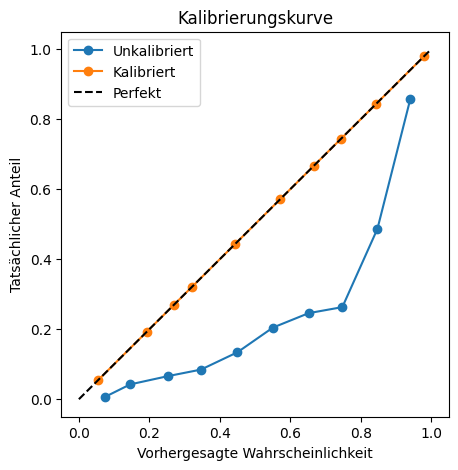

Brier Score (Kalibriert): 0.1


In [16]:
# Isotonic Kalibrierung
calib_clf = CalibratedClassifierCV(final_pipe, method='isotonic', cv='prefit')
calib_clf.fit(X_val, y_val)
probas_cal = calib_clf.predict_proba(X_val)[:, 1]


# Kalibrier-Kurve erstellen
fraction_raw, mean_pred_raw = calibration_curve(y_val, y_val_proba, n_bins=10)
fraction_cal, mean_pred_cal = calibration_curve(y_val, probas_cal, n_bins=10)

plt.figure(figsize=(5,5))
plt.plot(mean_pred_raw, fraction_raw, "o-", label="Unkalibriert")
plt.plot(mean_pred_cal, fraction_cal, "o-", label="Kalibriert")
plt.plot([0,1], [0,1], "k--", label="Perfekt")
plt.xlabel("Vorhergesagte Wahrscheinlichkeit")
plt.ylabel("Tatsächlicher Anteil")
plt.title("Kalibrierungskurve")
plt.legend()
plt.show()


print("Brier Score (Kalibriert):", round(brier_score_loss(y_val, probas_cal),2))

### Threshhold

Min. Kosten: 23900 @ Threshhold: 0.67


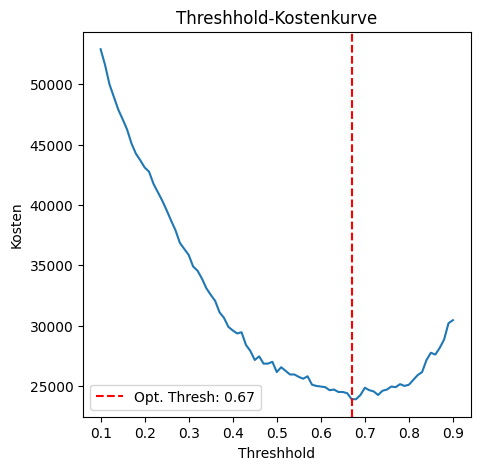

Min. Kosten (kalibriert): 23700 @ Threshhold: 0.21


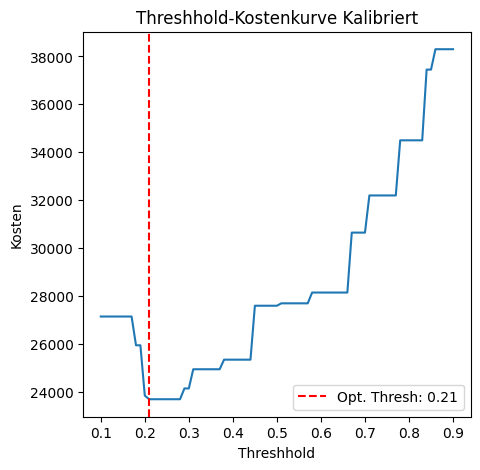

In [17]:
# Kostenfunktion
def cost_function(y_true, y_pred, cac=cfg.CAC, rc=cfg.RC):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return fn * cac + fp * rc

# Threshhold unkalibriertes Modell
thresholds = np.arange(0.1, 0.91, 0.01)
costs = []
for th in thresholds:
    preds = (y_val_proba >= th).astype(int)
    cost = cost_function(y_val, preds)
    costs.append(cost)
best_th = thresholds[np.argmin(costs)]
print("Min. Kosten:", min(costs), "@ Threshhold:", round(best_th, 2))

plt.figure(figsize=(5,5))
plt.plot(thresholds, costs, '-')
plt.axvline(best_th, color='r', linestyle='--', label=f"Opt. Thresh: {round(best_th,2)}")
plt.xlabel("Threshhold")
plt.ylabel("Kosten")
plt.title("Threshhold-Kostenkurve")
plt.legend()
plt.show()

# Threshhol nach Kalibrierung
thresholds = np.arange(0.1, 0.91, 0.01)
costs = []
for th in thresholds:
    preds = (probas_cal >= th).astype(int)    # <-- benutze hier probas_cal!
    cost = cost_function(y_val, preds)
    costs.append(cost)
best_th = thresholds[np.argmin(costs)]
print("Min. Kosten (kalibriert):", min(costs), "@ Threshhold:", round(best_th, 2))

plt.figure(figsize=(5,5))
plt.plot(thresholds, costs, '-')
plt.axvline(best_th, color='r', linestyle='--', label=f"Opt. Thresh: {round(best_th,2)}")
plt.xlabel("Threshhold")
plt.ylabel("Kosten")
plt.title("Threshhold-Kostenkurve Kalibriert")
plt.legend()
plt.show()

### Lernkurve

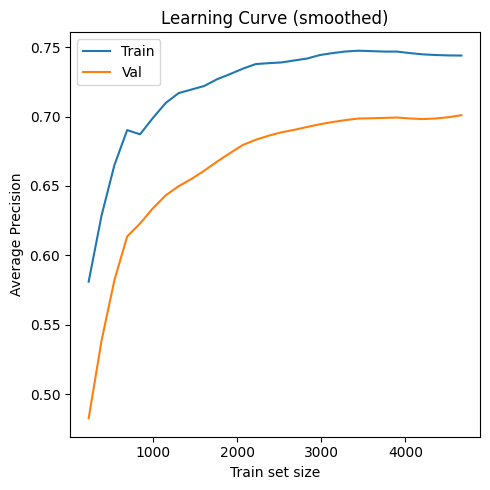

Finales Generalisierungs-Gap: 0.043
Train score: 0.744 | Val score: 0.701


In [18]:
train_sizes, train_scores, val_scores = learning_curve(
    final_pipe, X_train, y_train,
    cv=cv, scoring=cfg.REFIT_SCORE,
    train_sizes=np.linspace(0.05, 1.0, 30),
    n_jobs=-1
)

mean_train = np.mean(train_scores, axis=1)
mean_val   = np.mean(val_scores, axis=1)

# Glätten mit Savitzky-Golay-Filter
mean_train_smooth = savgol_filter(mean_train, window_length=7, polyorder=2)
mean_val_smooth   = savgol_filter(mean_val,   window_length=7, polyorder=2)

plt.figure(figsize=(5,5))
plt.plot(train_sizes, mean_train_smooth, '-', label='Train')
plt.plot(train_sizes, mean_val_smooth, '-', label='Val')
plt.xlabel('Train set size')
plt.ylabel('Average Precision')
plt.legend()
plt.title('Learning Curve (smoothed)')
plt.tight_layout()
plt.show()

# Generalisierungs-Gap
gap = mean_train[-1] - mean_val[-1]
print(f"Finales Generalisierungs-Gap: {gap:.3f}")
print(f"Train score: {mean_train[-1]:.3f} | Val score: {mean_val[-1]:.3f}")

**Ergebnisse:**

* Min. Kosten: 23k € bei optimalem Schwellenwert (kalibriert) 0.21 
* Brier Score (kalibriert): 0.1
* Unterschied avg precision (rechts) 0.043 (Train: 0.74 | Val: 0.7) 

**Schlussfolgerung:**

* Kosten und Schwellenwert sind daten- und businessgetrieben optimiert.
* Die Kalibrierung funktioniert gut, Wahrscheinlichkeiten können direkt für Schwellenwertanpassungen/Kosten genutzt werden.
* Ok Gap mit 0.4, kein starkes Overfitting, Modell verallgemeinert -> es kann weitergemacht werden


## Evaluation auf Test

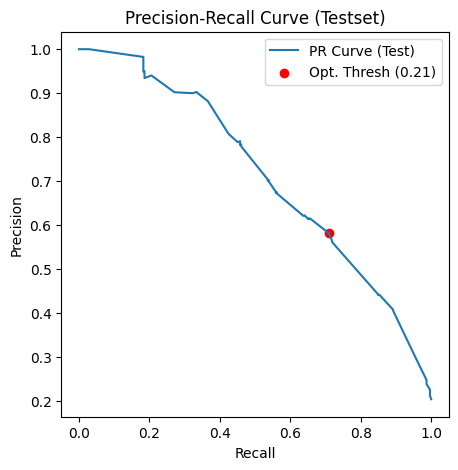

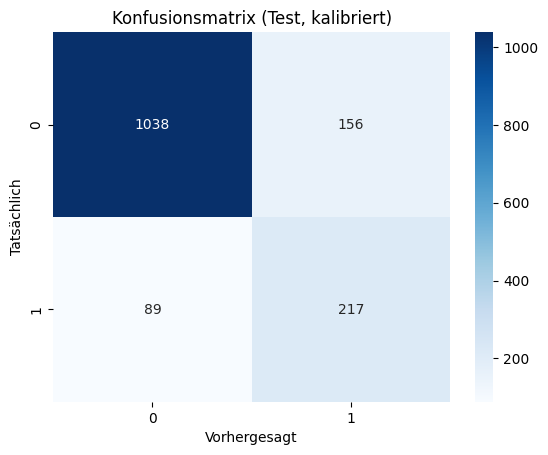

,Val_average_precision,Val_Recall,Val_Precision,Confusion_Matrix
0,0.68,0.8,0.42,"[[851, 343], [60, 246]]"


,Test_average_precision,Test_Recall,Test_Precision,Confusion_Matrix
0,0.69,0.71,0.58,"[[1038, 156], [89, 217]]"


In [19]:
# Testdaten durch finale Pipeline
y_test_pred  = final_pipe.predict(X_test)
y_test_proba = final_pipe.predict_proba(X_test)[:, 1]

# Kalibrierung auf Testdaten anwenden
probas_test_cal = calib_clf.predict_proba(X_test)[:, 1]

# PR Curve mit Marker für optimalen Schwellenwert
prec, rec, thres = precision_recall_curve(y_test, probas_test_cal)
plt.figure(figsize=(5, 5))
plt.plot(rec, prec, label='PR Curve (Test)')
plt.scatter(
    recall_score(y_test, (probas_test_cal >= best_th).astype(int)),
    precision_score(y_test, (probas_test_cal >= best_th).astype(int)),
    color='red', label=f'Opt. Thresh ({best_th:.2f})'
)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Testset)')
plt.legend()
plt.show()

# Konfusionsmatrix
cm = confusion_matrix(y_test, (probas_test_cal >= best_th).astype(int))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.title("Konfusionsmatrix (Test, kalibriert)")
plt.show()

# Metriken berechnen
test_metrics = pd.DataFrame([{
    "Test_average_precision": average_precision_score(y_test, probas_test_cal),
    "Test_Recall": recall_score(y_test, (probas_test_cal >= best_th).astype(int)),
    "Test_Precision": precision_score(y_test, (probas_test_cal >= best_th).astype(int)),
    "Confusion_Matrix": cm.tolist()
}]).round(2)

display(df_result[["Val_average_precision", "Val_Recall", "Val_Precision", "Confusion_Matrix"]])
display(test_metrics)

**Schlussfolgerung**  
XGBoost mit Optuna-Tuning, Kalibrierung und kostenoptimiertem Threshold liefert robuste, kostenbewusste Churn-Vorhersagen mit guter Balance zwischen Recall und Precision, was die final mit dem Test-Datensatz untermauert wird.



# Explainability
Im Rahmen der Stakeholder Transparenz & Akzeptanz sowie beispielhaft für Regulatorik im Rahmen des EU AI Acts

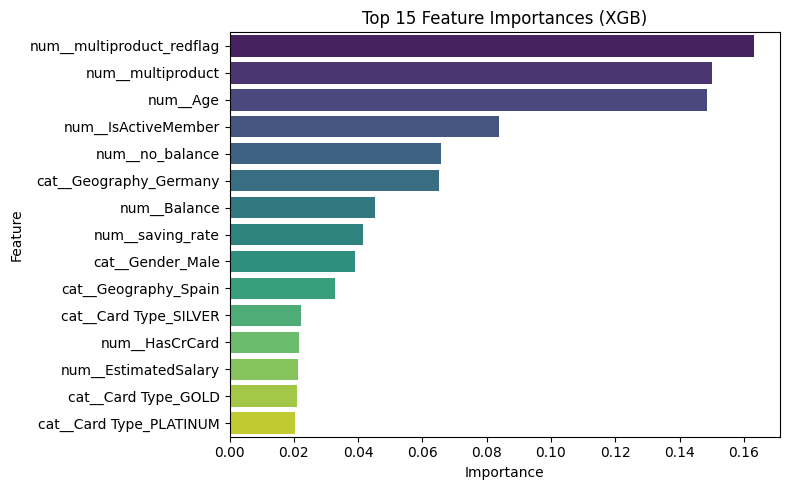

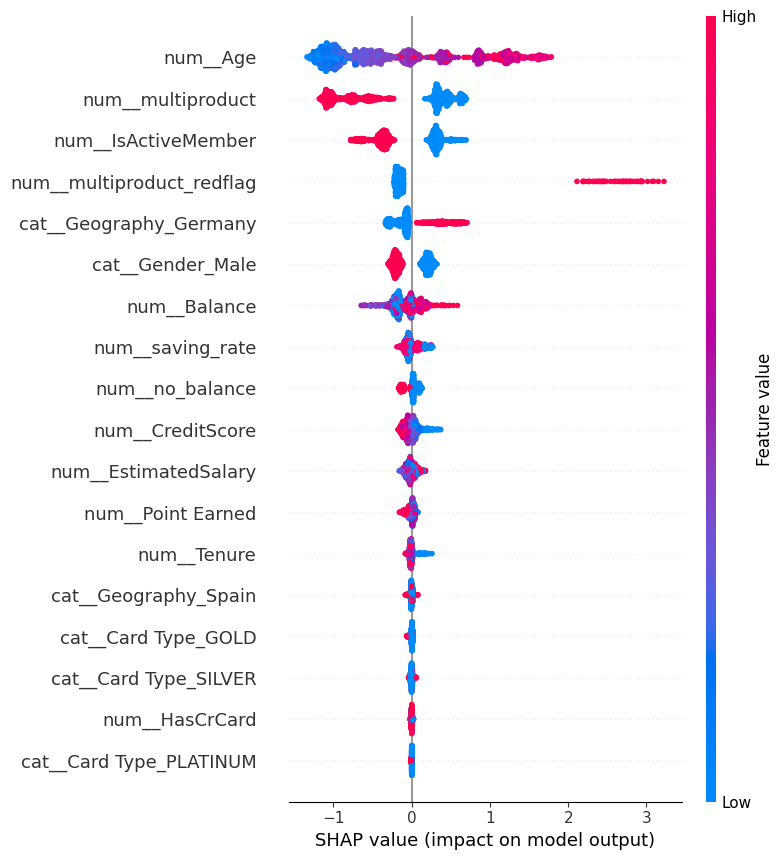

Ausgewählter Kunde Index: 189, Vorhersage: 1.00


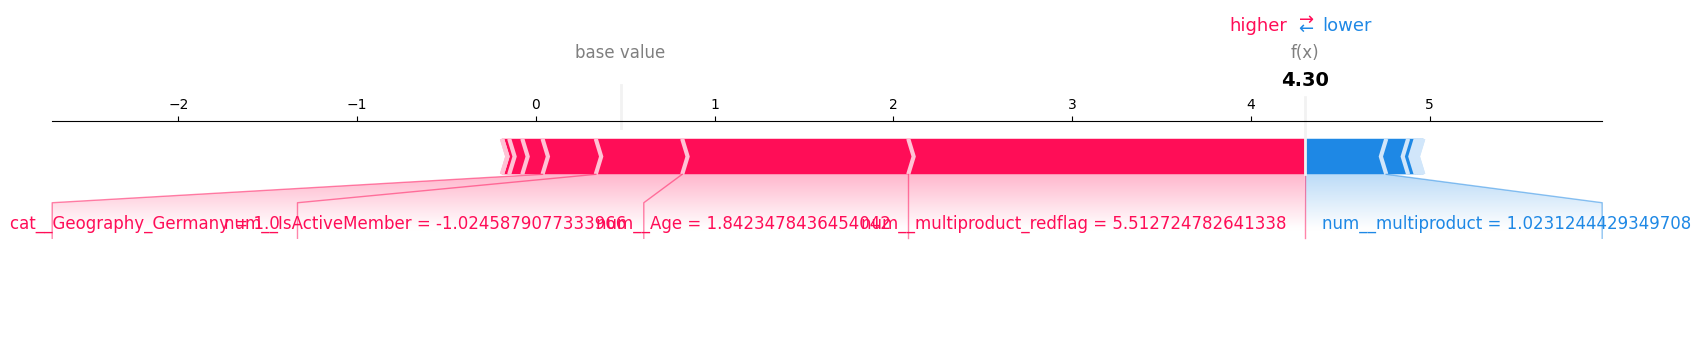

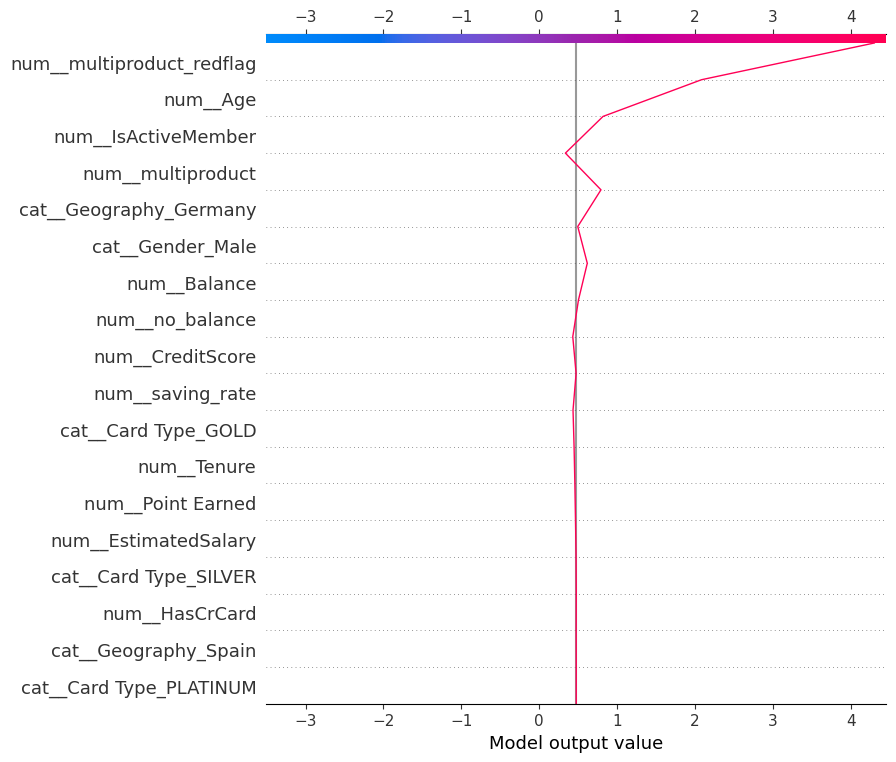

In [20]:
# Feature Importance
feature_names = final_pipe.named_steps['preprocessing'].get_feature_names_out()
importances = final_xgb.feature_importances_

fi = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=fi.head(15), x="Importance", y="Feature", palette="viridis")
plt.title("Top 15 Feature Importances (XGB)")
plt.tight_layout()
plt.show()

# SHAP Global
feature_eng = final_pipe.named_steps['feature_eng']
preprocessor = final_pipe.named_steps['preprocessing']

X_test_fe = feature_eng.transform(X_test)
X_test_transformed = preprocessor.transform(X_test_fe)

explainer = shap.TreeExplainer(final_xgb)
shap_values = explainer.shap_values(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

# Auswahl: Kunde mit höchstem Churn-Risiko
customer_idx = np.argmax(probas_test_cal)
print(f"Ausgewählter Kunde Index: {customer_idx}, Vorhersage: {probas_test_cal[customer_idx]:.2f}")

x_customer = X_test_transformed[[customer_idx]]

# SHAP Local – Force Plot
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[customer_idx, :],
    x_customer,
    feature_names=feature_names,
    matplotlib=True
)

# SHAP Decision Plo
shap.decision_plot(
    explainer.expected_value,
    shap_values[customer_idx, :],
    feature_names=feature_names
)